Importing Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy import linalg as LA

ETF function definition

In [2]:
def etf(img,mu=2,iter=1):
  img = img/255.0
  img_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
  img_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
  img_x = np.pad(img_x,mu)
  img_y = np.pad(img_y,mu)
  tangx = -1*img_y.copy()
  tangy = img_x.copy()
  tang_sqrt = np.sqrt(tangx*tangx+tangy*tangy)
  np.place(tang_sqrt,tang_sqrt==0,[1])
  tangx = tangx/tang_sqrt
  tangy = tangy/tang_sqrt
  img_m = np.sqrt(np.multiply(img_x,img_x)+np.multiply(img_y,img_y))
  img_m = img_m/np.max(img_m)
  for iteration in range(iter):
    img_outx = np.zeros((img.shape[0]+2*mu,img.shape[1]+2*mu))
    img_outy = np.zeros((img.shape[0]+2*mu,img.shape[1]+2*mu))
    for i in range(mu,img.shape[0]+mu):
      for j in range(mu,img.shape[1]+mu):
        wmx = (img_m[i-mu:i+mu+1,j-mu:j+mu+1] - img_m[i,j] + 1)/2
        wmy = (img_m[i-mu:i+mu+1,j-mu:j+mu+1] - img_m[i,j] + 1)/2
        wdx = (tangx[i-mu:i+mu+1,j-mu:j+mu+1]*tangx[i,j])
        wdy = (tangy[i-mu:i+mu+1,j-mu:j+mu+1]*tangy[i,j])
        weight_x = np.multiply(wmx,wdx)
        weight_y = np.multiply(wmy,wdy)
        img_outx[i,j] = np.sum(np.multiply(weight_x+weight_y,tangx[i-mu:i+mu+1,j-mu:j+mu+1]))
        img_outy[i,j] = np.sum(np.multiply(weight_x+weight_y,tangy[i-mu:i+mu+1,j-mu:j+mu+1]))
    tangx = img_outx.copy()
    tangy = img_outy.copy()
  tang = [tangx[mu:img.shape[0]+mu,mu:img.shape[1]+mu],tangy[mu:img.shape[0]+mu,mu:img.shape[1]+mu]]
  tang_sqrt = np.sqrt(tang[0]*tang[0]+tang[1]*tang[1])
  np.place(tang_sqrt,tang_sqrt==0,[1])
  tang = tang/tang_sqrt
  return tang

Defining Necessary Functions for efficient implementation of FDoG.

In [3]:
def neighbour_from_angle(angle):
    angles = [0,45,90,135,180,225,270,315,360]
    deltas = [(0,1),(-1,1),(-1,0),(-1,-1),(0,-1),(1,-1),(1,0),(1,1),(0,1)]

    for i in range(9):
        if(abs(angles[i]-angle) <= 22.5):
            return deltas[i]

def angle_from_flow(x,y):
    if(x == 0):
        return np.pi/2

    angle = np.arctan(abs(y)/abs(x))

    if(x>0 and y>=0):
        return (2*np.pi - angle)
  
    if(x>0 and y<0):
        return angle
  
    if(x<0 and y<0):
        return (np.pi - angle)
  
    if(x<0 and y>=0):
        return (np.pi + angle)

def Gaussian(x,sigma):
    return (1/np.sqrt(2*np.pi*sigma))*np.exp(-x**2/(2*sigma**2))

def DoG_filter(t,c,p):
    return (Gaussian(t,c) - p*Gaussian(t,1.05*c))
def intensity_weight(im1, im2, sigma):
    I = np.dot(im1-im2,im1-im2)
    return (1/np.sqrt(2*np.pi*sigma))*np.exp(-I**2/(2*sigma**2))

FDoG definition

In [4]:
def FDoG_basic(image, ETF):

  H0 = np.zeros((image.shape[0],image.shape[1]))

  for i in range(image.shape[0]):
    for j in range(image.shape[1]):

      angle_normal = (angle_from_flow(ETF[i,j,0],ETF[i,j,1]) + np.pi/2)%(2*np.pi)

      delta = neighbour_from_angle(angle_normal*180/np.pi)

      for t in range(int(-1*3*np.ceil(c)),int(3*np.ceil(c)+1)):
        if(i+t*delta[0] < 0 or i+t*delta[0] >= image.shape[0] or j+t*delta[1] < 0 or j+t*delta[1] >= image.shape[1]):
          continue

        H0[i,j] = H0[i,j] + image[i+t*delta[0],j+t*delta[1]]*DoG_filter(t,c,p)
  
  H = np.zeros((image.shape[0],image.shape[1]))

  for i in range(image.shape[0]):
    for j in range(image.shape[1]):

      pixel = [i,j]
      delta = (0,0)
      s = 0
      weight = 0
      total_weight = 0

      for t in range(int(3*m)):

        if(pixel[0]<0 or pixel[0]>=image.shape[0] or pixel[1]<0 or pixel[1]>=image.shape[1]):
          continue

        s = s + np.sqrt(delta[0]**2 + delta[1]**2)
        weight = Gaussian(s,m)
        H[i,j] = H[i,j] + H0[pixel[0],pixel[1]]*weight
        total_weight = total_weight + weight
        
        angle = angle_from_flow(ETF[pixel[0],pixel[1],0],ETF[pixel[0],pixel[1],1])
        delta = neighbour_from_angle(angle*180/np.pi)
        pixel = [pixel[0]+delta[0], pixel[1]+delta[1]]

      pixel = [i,j]
      delta = (0,0)
      s = 0

      for t in np.flip(range(int(-3*m),0)):

        if(pixel[0]<0 or pixel[0]>=image.shape[0] or pixel[1]<0 or pixel[1]>=image.shape[1]):
          continue

        angle = angle_from_flow(ETF[pixel[0],pixel[1],0],ETF[pixel[0],pixel[1],1])
        delta = neighbour_from_angle(angle*180/np.pi)
        pixel = [pixel[0]-delta[0], pixel[1]-delta[1]]

        if(pixel[0]<0 or pixel[0]>=image.shape[0] or pixel[1]<0 or pixel[1]>=image.shape[1]):
          continue

        s = s + np.sqrt(delta[0]**2 + delta[1]**2)
        weight = Gaussian(s,m)
        H[i,j] = H[i,j] + H0[pixel[0],pixel[1]]*weight
        total_weight = total_weight + weight

      H[i,j] = H[i,j]/total_weight

  return H

def FDoG(image, ETF, iter):

  H = FDoG_basic(image, ETF)

  img1 = (H < 0).astype(int)
  img2 = (1 + np.tanh(H) < tau).astype(int)

  H = (1 - np.multiply(img1,img2))*255
  new_img = np.minimum(image,H)

  for i in range(iter-1):
    
    H = FDoG_basic(new_img, ETF)

    img1 = (H < 0).astype(int)
    img2 = (1 + np.tanh(H) < tau).astype(int)

    H = (1 - np.multiply(img1,img2))*255
    new_img = np.minimum(image,H)
  
  return H


Region Smoothing FBL

In [5]:
def FBL11(image, etf, iterations = 1): 
    size = image.shape
    H4 = image
    for i in range(iterations):
        H3 = np.zeros(size)
        for h in range(size[0]):
            for w in range(size[1]):
                total_weight = 0
                ang = angle_from_flow(etf[h][w][0],etf[h][w][1])
                pix = neighbour_from_angle(ang*180/np.pi)
                for j in range(-5,6):
                    if h + pix[0]*j < 0 or h + pix[0]*j >= size[0] or w + pix[1]*j < 0 or w + pix[1]*j >= size[1]:
                        continue
                    weight = Gaussian(abs(j),sig_spatial)*intensity_weight(H4[h][w],H4[h+pix[0]*j][w+pix[1]*j],sig_intensity1)
                    H3[h][w] += H4[h+pix[0]*j][w+pix[1]*j]*weight
                    total_weight += weight
                    
                H3[h][w] /= total_weight
        H4 = np.zeros(size)
        for h in range(size[0]):
            for w in range(size[1]):
                total_weight = 0
                angle_perpendicular = (angle_from_flow(etf[h][w][0],etf[h][w][1]) + np.pi/2)
                if angle_perpendicular > 2*np.pi:
                    angle_perpendicular -= 2*np.pi
                pix = neighbour_from_angle(angle_perpendicular*180/np.pi)
                for j in range(-5,6):
                    if h + pix[0]*j < 0 or h + pix[0]*j >= size[0] or w + pix[1]*j < 0 or w + pix[1]*j >= size[1]:
                        continue
                    weight = Gaussian(abs(j),sig_spatial)*intensity_weight(H3[h][w],H3[h+pix[0]*j][w+pix[1]*j],sig_intensity2)
                    H4[h][w] += H3[h+pix[0]*j][w+pix[1]*j]*weight
                    total_weight += weight
                H4[h][w] /= total_weight
    return H4


In [5]:
def FBL(image, ETF, iter=1):

  H = image
  for iteration in range(iter):
    H0 = np.zeros(image.shape)
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):

        pixel = [i,j]
        delta = (0,0)
        s = 0
        weight = 0
        total_weight = 0

        for t in range(3*int(sig_spatial)+1):

          if(pixel[0]<0 or pixel[0]>=image.shape[0] or pixel[1]<0 or pixel[1]>=image.shape[1]):
            continue

          s = s + np.sqrt(delta[0]**2 + delta[1]**2)
          weight = Gaussian(s,sig_spatial)*Gaussian(np.sqrt(np.sum((H[i,j]-H[pixel[0],pixel[1]])**2)),sig_int1)
          H0[i,j] = H0[i,j] + H[pixel[0],pixel[1]]*weight
          total_weight = total_weight + weight
          
          angle = angle_from_flow(ETF[pixel[0],pixel[1],0],ETF[pixel[0],pixel[1],1])
          delta = neighbour_from_angle(angle*180/np.pi)
          pixel = [pixel[0]+delta[0], pixel[1]+delta[1]]

        pixel = [i,j]
        delta = (0,0)
        s = 0

        for t in np.flip(range(-1*3*int(sig_spatial),0)):

          if(pixel[0]<0 or pixel[0]>=image.shape[0] or pixel[1]<0 or pixel[1]>=image.shape[1]):
            continue

          angle = angle_from_flow(ETF[pixel[0],pixel[1],0],ETF[pixel[0],pixel[1],1])
          delta = neighbour_from_angle(angle*180/np.pi)
          pixel = [pixel[0]-delta[0], pixel[1]-delta[1]]

          if(pixel[0]<0 or pixel[0]>=image.shape[0] or pixel[1]<0 or pixel[1]>=image.shape[1]):
            continue

          s = s + np.sqrt(delta[0]**2 + delta[1]**2)
          weight = Gaussian(s,sig_spatial)*Gaussian(np.sqrt(np.sum((H[i,j]-H[pixel[0],pixel[1]])**2)),sig_int1)
          H0[i,j] = H0[i,j] + H[pixel[0],pixel[1]]*weight
          total_weight = total_weight + weight

        H0[i,j] = H0[i,j]/total_weight

    H = np.zeros(image.shape)  
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):

        angle_normal = (angle_from_flow(ETF[i,j,0],ETF[i,j,1]) + np.pi/2)%(2*np.pi)

        delta = neighbour_from_angle(angle_normal*180/np.pi)
        total_weight = 0

        for t in range(-1*3*int(sig_spatial),3*int(sig_spatial)+1):
          if(i+t*delta[0] < 0 or i+t*delta[0] >= image.shape[0] or j+t*delta[1] < 0 or j+t*delta[1] >= image.shape[1]):
            continue

          weight = Gaussian(t,sig_spatial)*Gaussian(np.sqrt(np.sum((H0[i,j]-H0[i+t*delta[0],j+t*delta[1]])**2)),sig_int2)
          H[i,j] = H[i,j] + H0[i+t*delta[0],j+t*delta[1]]*weight
          total_weight = total_weight + weight
        
        H[i,j] = H[i,j]/total_weight

  return H

Main Function begins here

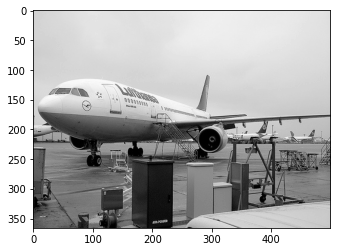

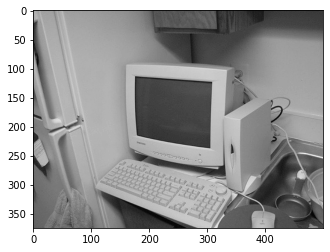

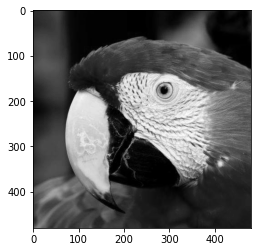

In [7]:
img1 = cv2.imread('aeroplane_original.jpg')
imm1 = np.array(img1)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread('computer_original.jpg')
imm2 = np.array(img2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

img3 = cv2.imread('macaw_original.jpg')
imm3 = np.array(img3)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

plt.imshow(img1,cmap='gray')
plt.show()
plt.imshow(img2,cmap='gray')
plt.show()
plt.imshow(img3,cmap='gray')
plt.show()

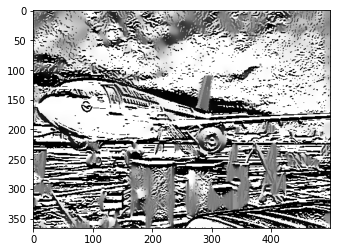

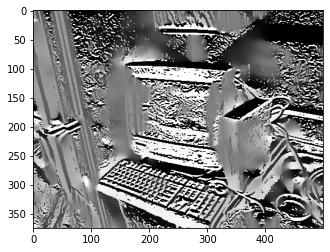

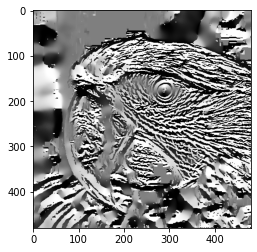

In [8]:
tang1 = etf(img1, mu=5,iter=3)
tang_flow1 = np.stack([tang1[0],tang1[1]],axis=2)
plt.imshow(tang_flow1[:,:,0],cmap='gray')
plt.show()
tang2 = etf(img2, mu=5,iter=3)
tang_flow2 = np.stack([tang2[0],tang2[1]],axis=2)
plt.imshow(tang_flow2[:,:,0],cmap='gray')
plt.show()
tang3 = etf(img3, mu=5,iter=3)
tang_flow3 = np.stack([tang3[0],tang3[1]],axis=2)
plt.imshow(tang_flow3[:,:,0],cmap='gray')
plt.show()

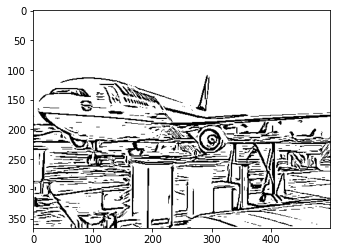

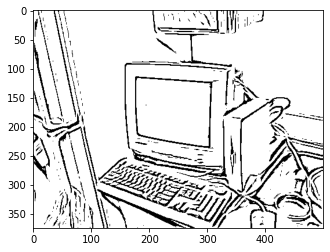

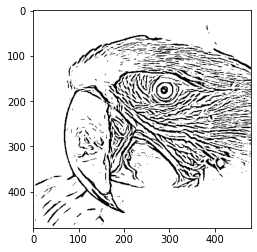

In [9]:
m = 3
c = 1
p = 0.9761
tau = 0.9
edges1 = FDoG(img1, tang_flow1, iter=1)
plt.imshow(edges1, cmap='gray')
plt.show()

edges2 = FDoG(img2, tang_flow2, iter=1)
plt.imshow(edges2, cmap='gray')
plt.show()

edges3 = FDoG(img3, tang_flow3, iter=1)
plt.imshow(edges3, cmap='gray')
plt.show()

**FLOW-BASED BILATERAL FILTER**

In [12]:
sig_spatial = 2.0
sig_int1 = 50.0
sig_int2 = 100.0
out1 = np.zeros(imm1.shape)
out1=FBL(imm1, tang_flow1, iter = 1)/255.0

out2 = np.zeros(imm2.shape)
out2=FBL(imm2, tang_flow2, iter = 1)/255.0

out3 = np.zeros(imm3.shape)
out3=FBL(imm3, tang_flow3, iter = 1)/255.0

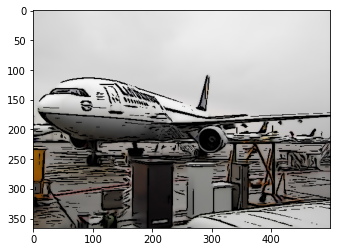

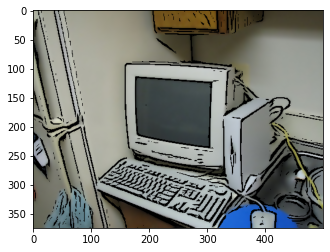

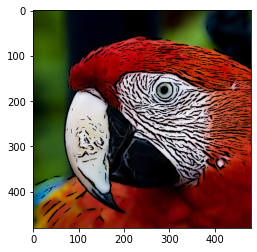

In [13]:
output1 = np.zeros(imm1.shape)
output1[:,:,0] = np.array((out1[:,:,2]*edges1/255.0),dtype=np.float32)
output1[:,:,1] = np.array((out1[:,:,1]*edges1/255.0),dtype=np.float32)
output1[:,:,2] = np.array((out1[:,:,0]*edges1/255.0),dtype=np.float32)

plt.imshow(output1)
plt.show()

output2 = np.zeros(imm2.shape)
output2[:,:,0] = np.array((out2[:,:,2]*edges2/255.0),dtype=np.float32)
output2[:,:,1] = np.array((out2[:,:,1]*edges2/255.0),dtype=np.float32)
output2[:,:,2] = np.array((out2[:,:,0]*edges2/255.0),dtype=np.float32)

plt.imshow(output2)
plt.show()

output3 = np.zeros(imm3.shape)
output3[:,:,0] = np.array((out3[:,:,2]*edges3/255.0),dtype=np.float32)
output3[:,:,1] = np.array((out3[:,:,1]*edges3/255.0),dtype=np.float32)
output3[:,:,2] = np.array((out3[:,:,0]*edges3/255.0),dtype=np.float32)

plt.imshow(output3)
plt.show()

In [18]:
from PIL import Image
im1 = Image.fromarray((output1* 255).astype(np.uint8))
im1.save('cartoon_aeroplane.jpg')
im2 = Image.fromarray((output2* 255).astype(np.uint8))
im2.save('cartoon_computer.jpg')
im3 = Image.fromarray((output3* 255).astype(np.uint8))
im3.save('cartoon_macaw.jpg')